## Strategy Development Summary

### ✅ Current Implementation
- **Strategy Type**: Multi-timeframe EMA Crossover (9/21/50/200)
- **Entry Logic**: 
  - Bullish: EMA 9 > EMA 21 AND EMA 21 > EMA 50 AND Price > EMA 200
  - Bearish: EMA 9 < EMA 21 AND EMA 21 < EMA 50 AND Price < EMA 200
- **Backtest Engine**: Vectorized with PnL, Sharpe ratio, max drawdown
- **Optimization**: Grid search untuk EMA parameters

### 📊 Key Metrics
- Total Return
- Annualized Return & Volatility
- Sharpe Ratio
- Maximum Drawdown
- Win Rate
- Trade Count

### 🔧 Next Steps untuk Enhance Strategi
1. **Add Stop Loss**: Set ATR-based stops untuk risk management
2. **Position Sizing**: Kelly Criterion atau Fixed Fractional sizing
3. **Risk Management**: Max loss per trade, daily loss limit
4. **Additional Filters**:
   - RSI untuk oversold/overbought (30/70)
   - Volume filter (high volume confirmation)
   - ADX untuk trend strength
5. **Walk-Forward Optimization**: Out-of-sample testing
6. **Compare with Benchmark**: BNB buy-hold vs strategy
7. **Live Backtesting**: Test di fresh data (2025 onwards)

### 💡 Tuning Ideas
- Tambah trailing stop untuk capture trends lebih lama
- Dynamic EMA periods based on volatility
- Multi-instrument correlation (BNB + ETH + BTC)
- Time-based filters (avoid low-volume sessions)
- Combine dengan mean-reversion untuk counter-trades

In [1]:
from statsmodels.regression.rolling import RollingOLS
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np
import datetime as dt
import yfinance as yf
import pandas_ta
import ta
from ta.utils import dropna
import warnings
warnings.filterwarnings('ignore')

/opt/anaconda3/envs/quant-finance/lib/python3.11/site-packages/pandas_ta/__init__.py:7: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import get_distribution, DistributionNotFound


In [2]:
help(yf.download)

Help on function download in module yfinance.multi:

download(tickers, start=None, end=None, actions=False, threads=True, ignore_tz=None, group_by='column', auto_adjust=None, back_adjust=False, repair=False, keepna=False, progress=True, period=None, interval='1d', prepost=False, proxy=<object object at 0x16b06ddb0>, rounding=False, timeout=10, session=None, multi_level_index=True) -> Optional[pandas.core.frame.DataFrame]
    Download yahoo tickers
    :Parameters:
        tickers : str, list
            List of tickers to download
        period : str
            Valid periods: 1d,5d,1mo,3mo,6mo,1y,2y,5y,10y,ytd,max
            Default: 1mo
            Either Use period parameter or use start and end
        interval : str
            Valid intervals: 1m,2m,5m,15m,30m,60m,90m,1h,1d,5d,1wk,1mo,3mo
            Intraday data cannot extend last 60 days
        start: str
            Download start date string (YYYY-MM-DD) or _datetime, inclusive.
            Default is 99 years ago
       

In [4]:
# scrape data from yfinance (download historical market data from Yahoo Finance)
# download BNB USD data from January 1, 2020 to January 1, 2023
start_date = "2020-01-01"
end_date = "2025-12-11"
ticker = "BNB-USD"

df = yf.download(tickers=ticker, 
                 start=start_date, 
                 end=end_date, 
                 interval="1d",
                 multi_level_index=False,
                 auto_adjust=True,
                 prepost=False,
                 threads=True,
                 proxy=None)

df.tail()

[*********************100%***********************]  1 of 1 completed


,Close,High,Low,Open,Volume
Date,,,,,
2025-12-06,890.545044,896.655823,878.983826,884.212769,1418385761
2025-12-07,894.022278,905.114502,872.894592,890.526672,1779976227
2025-12-08,897.604065,911.538635,891.778992,894.027344,1906067258
2025-12-09,898.810425,926.517090,882.407227,897.590637,2357057936
2025-12-10,894.650635,914.186401,884.947510,898.780579,2429639422


In [6]:
# save data to csv file
path = "/Users/Documents/Vs-Code Project/Quantitative Finance – Stocks & Crypto/Projects/01_moving_average_crossover/data"
df.to_csv(f"{path}/BNB_USD.csv")


In [3]:
help(pandas_ta.momentum.stochrsi)

Help on function stochrsi in module pandas_ta.momentum.stochrsi:

stochrsi(close, length=None, rsi_length=None, k=None, d=None, mamode=None, offset=None, **kwargs)
    Stochastic (STOCHRSI)
    
    "Stochastic RSI and Dynamic Momentum Index" was created by Tushar Chande and Stanley Kroll and published in Stock & Commodities V.11:5 (189-199)
    
    It is a range-bound oscillator with two lines moving between 0 and 100.
    The first line (%K) displays the current RSI in relation to the period's
    high/low range. The second line (%D) is a Simple Moving Average of the %K line.
    The most common choices are a 14 period %K and a 3 period SMA for %D.
    
    Sources:
        https://www.tradingview.com/wiki/Stochastic_(STOCH)
    
    Calculation:
        Default Inputs:
            length=14, rsi_length=14, k=3, d=3
        RSI = Relative Strength Index
        SMA = Simple Moving Average
    
        RSI = RSI(high, low, close, rsi_length)
        LL  = lowest RSI for last rsi_leng

In [4]:
# check dataframe index and columns
df.index

DatetimeIndex(['2020-01-01', '2020-01-02', '2020-01-03', '2020-01-04',
               '2020-01-05', '2020-01-06', '2020-01-07', '2020-01-08',
               '2020-01-09', '2020-01-10',
               ...
               '2025-12-01', '2025-12-02', '2025-12-03', '2025-12-04',
               '2025-12-05', '2025-12-06', '2025-12-07', '2025-12-08',
               '2025-12-09', '2025-12-10'],
              dtype='datetime64[ns]', name='Date', length=2171, freq=None)

In [5]:
df.isnull().sum()

Close     0
High      0
Low       0
Open      0
Volume    0
dtype: int64

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2171 entries, 2020-01-01 to 2025-12-10
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   2171 non-null   float64
 1   High    2171 non-null   float64
 2   Low     2171 non-null   float64
 3   Open    2171 non-null   float64
 4   Volume  2171 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 101.8 KB


In [7]:
# make all column names lowercase
df.columns = df.columns.str.lower()

# change Date column to datetime format
df.index = pd.to_datetime(df.index)

# change "Date" to "date" in index name
df.index.rename('date', inplace=True)

df.head()

,close,high,low,open,volume
date,,,,,
2020-01-01,13.689083,13.873946,13.654942,13.730962,172980718
2020-01-02,13.027011,13.715548,12.989974,13.698126,156376427
2020-01-03,13.660452,13.763709,13.012638,13.035329,173683857
2020-01-04,13.891512,13.921914,13.560008,13.667442,182230374
2020-01-05,14.111019,14.410801,13.886547,13.888340,202552703


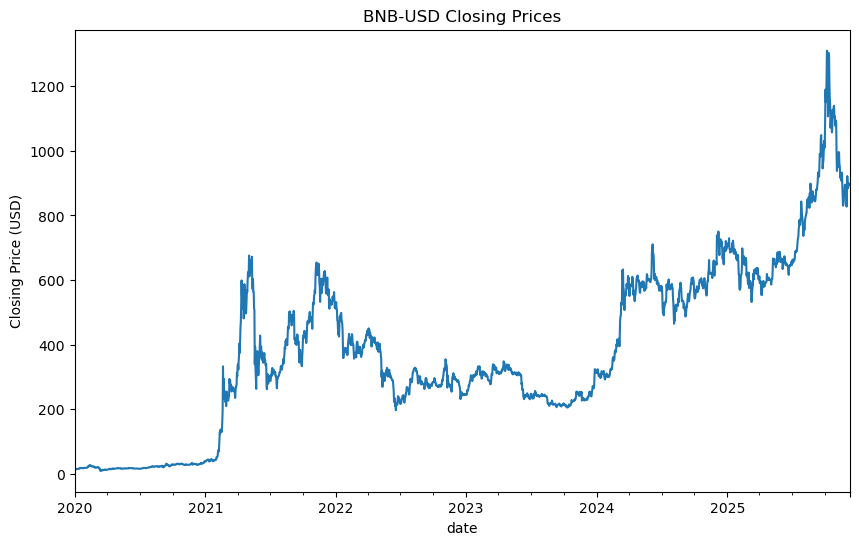

In [8]:
# analyze BNB USD data using pandas and visualize using matplotlib and seaborn
df['close'].plot(title='BNB-USD Closing Prices', figsize=(10, 6))
plt.xlabel('date')
plt.ylabel('Closing Price (USD)')
plt.show()

## 2. Calculate features and technical indicators for Financial Instrument.

* Garman-Klass Volatility
* RSI
* Bollinger Bands
* ATR
* MACD
* Dollar Volume

\begin{equation}
\text{Garman-Klass Volatility} = \frac{(\ln(\text{High}) - \ln(\text{Low}))^2}{2} - (2\ln(2) - 1)(\ln(\text{Adj Close}) - \ln(\text{Open}))^2
\end{equation}

In [9]:
# Calculate technical indicator Garman-Klass Volatility
df['garman_klass_vol'] = ((np.log(df['high'])-np.log(df['low']))**2)/2-(2*np.log(2)-1)*((np.log(df['close'])-np.log(df['open']))**2)

In [10]:
# Calculate 20-day Relative Strength Index (RSI)
df['rsi'] = pandas_ta.rsi(close=df['close'], length=20)

In [11]:
# open Bollinger Bands documentation
help(pandas_ta.bbands)

Help on function bbands in module pandas_ta.volatility.bbands:

bbands(close, length=None, std=None, ddof=0, mamode=None, talib=None, offset=None, **kwargs)
    Bollinger Bands (BBANDS)
    
    A popular volatility indicator by John Bollinger.
    
    Sources:
        https://www.tradingview.com/wiki/Bollinger_Bands_(BB)
    
    Calculation:
        Default Inputs:
            length=5, std=2, mamode="sma", ddof=0
        EMA = Exponential Moving Average
        SMA = Simple Moving Average
        STDEV = Standard Deviation
        stdev = STDEV(close, length, ddof)
        if "ema":
            MID = EMA(close, length)
        else:
            MID = SMA(close, length)
    
        LOWER = MID - std * stdev
        UPPER = MID + std * stdev
    
        BANDWIDTH = 100 * (UPPER - LOWER) / MID
        PERCENT = (close - LOWER) / (UPPER - LOWER)
    
    Args:
        close (pd.Series): Series of 'close's
        length (int): The short period. Default: 5
        std (int): The long 

In [12]:
# calculate Bollinger Bands and add to dataframe
df['bb_lower'] = pandas_ta.bbands(close=df['close'], length=20).iloc[:,0]
df['bb_middle'] = pandas_ta.bbands(close=df['close'], length=20).iloc[:,1]
df['bb_upper'] = pandas_ta.bbands(close=df['close'], length=20).iloc[:,2]

In [13]:
# calculate ATR (Average True Range)
df['atr'] = pandas_ta.atr(high=df['high'], low=df['low'], close=df['close'], length=14)

In [14]:
# calculate macd indicator
def compute_macd(close):
    macd = pandas_ta.macd(close=close, length=20).iloc[:,0]
    return macd.sub(macd.mean()).div(macd.std())

df['macd'] = compute_macd(df['close'])


In [15]:
# dollar volume index (DVI)
df['dollar_volume'] = (df['close'] * df['volume'])/1e6

In [16]:
# --- Hitung EMA ---
df['EMA_9']   = df['close'].ewm(span=9,  adjust=False).mean()
df['EMA_21']  = df['close'].ewm(span=21, adjust=False).mean()
df['EMA_50']  = df['close'].ewm(span=50, adjust=False).mean()
df['EMA_200'] = df['close'].ewm(span=200,adjust=False).mean()

In [17]:
# calculate monthly returns for BNB-USD
df['monthly_return'] = df['close'].pct_change(periods=26)  # 21 trading days in a month
# change monthly return result to percent
df['monthly_return'] = df['monthly_return'] * 100
# calculate yearly returns for BNB-USD
df['1y_return'] = df['close'].pct_change(periods=312) # 312 trading days in a year
# change 1y return result to percent
df['1y_return'] = df['1y_return'] * 100

In [18]:
df.tail()

,close,high,low,open,volume,garman_klass_vol,rsi,bb_lower,bb_middle,bb_upper,atr,macd,dollar_volume,EMA_9,EMA_21,EMA_50,EMA_200,monthly_return,1y_return
date,,,,,,,,,,,,,,,,,,,
2025-12-06,890.545044,896.655823,878.983826,884.212769,1418385761,0.000178,45.428961,821.624417,878.068088,934.511758,41.846495,-1.342295,1.263136e+06,885.855180,897.401843,943.514297,881.615805,-10.220045,34.640456
2025-12-07,894.022278,905.114502,872.894592,890.526672,1779976227,0.000651,45.861373,822.003510,877.445081,932.886651,41.158882,-1.219258,1.591338e+06,887.488600,897.094610,941.573434,881.739253,-6.704139,33.898665
2025-12-08,897.604065,911.538635,891.778992,894.027344,1906067258,0.000234,46.322552,825.331936,875.701166,926.070395,39.630365,-1.094810,1.710894e+06,889.511693,897.140924,939.849145,881.897112,-5.813832,32.477206
2025-12-09,898.810425,926.517090,882.407227,897.590637,2357057936,0.001189,46.484173,825.220644,875.860703,926.500761,39.950329,-0.981307,2.118548e+06,891.371439,897.292697,938.239783,882.065403,-3.150295,32.690155
2025-12-10,894.650635,914.186401,884.947510,898.780579,2429639422,0.000520,45.981643,826.198638,877.276041,928.353443,39.185226,-0.901696,2.173678e+06,892.027278,897.052509,936.530405,882.190629,-2.257011,36.915451


## 3. Apply Crossover EMA Strategy

In [19]:
# Apply crossover EMA 50 and EMA 200 strategy with advanced exit conditions

df['signal'] = 0

# --- Logika Beli (Open Long) ---
# Kondisi Beli membutuhkan tiga hal:
# 1. Tren utama bullish: Price Close > EMA 200 & EMA 50 > EMA 200
# 2. Konfirmasi momentum: EMA 21 di atas EMA 50
# 3. Sinyal masuk: EMA 9 melintasi di atas EMA 21 (di periode sebelumnya berada di bawah)

Buy_Condition = (
    # Filter Tren Utama (Bullish Bias)
    (df['close'] > df['EMA_200'].shift(1)) & 
    (df['EMA_50'].shift(1) > df['EMA_200'].shift(1)) &
    
    # Konfirmasi Tren Menengah (Stacking)
    (df['EMA_21'].shift(1) > df['EMA_50'].shift(1)) & 
    
    # Sinyal Crossover (EMA 9 melintasi EMA 21 dari bawah ke atas)
    (df['EMA_9'] > df['EMA_21']) & 
    (df['EMA_9'].shift(1) <= df['EMA_21'].shift(1))
)

df.loc[Buy_Condition, 'signal'] = 1

# --- Logika Jual Short (Open Short) ---
# Kondisi Jual membutuhkan tiga hal:
# 1. Tren utama bearish: Harga di bawah EMA 200 DAN EMA 50 di bawah EMA 200
# 2. Konfirmasi momentum: EMA 21 di bawah EMA 50
# 3. Sinyal masuk: EMA 9 melintasi di bawah EMA 21 (di periode sebelumnya berada di atas)

Sell_Condition = (
    # Filter Tren Utama (Bearish Bias)
    (df['close'] < df['EMA_200'].shift(1)) & 
    (df['EMA_50'].shift(1) < df['EMA_200'].shift(1)) &
    
    # Konfirmasi Tren Menengah (Stacking Terbalik)
    (df['EMA_21'].shift(1) < df['EMA_50'].shift(1)) & 
    
    # Sinyal Crossover (EMA 9 melintasi EMA 21 dari atas ke bawah)
    (df['EMA_9'] < df['EMA_21']) & 
    (df['EMA_9'].shift(1) >= df['EMA_21'].shift(1))
)

df.loc[Sell_Condition, 'signal'] = -1

# --- Logika Close Long (Exit dari posisi LONG) ---
# Exit long jika SALAH SATU kondisi terpenuhi:
# 1. RSI > 70 (overbought)
# 2. Close < Bollinger Band lower (harga jatuh signifikan)
# 3. EMA 9 < EMA 50 (momentum melemah)
# 4. ATR meningkat drastis (volatility spike - tanda reversal)

Close_Long_Condition = (
    (df['signal'] == 0) &  # Only applicable when we're in a long position
    (
        (df['rsi'] > 70) |  # RSI overbought
        (df['close'] < df['bb_lower']) |  # Price below lower Bollinger Band
        (df['EMA_9'] < df['EMA_50']) |  # Fast EMA below mid EMA
        (df['atr'] > df['atr'].rolling(20).mean() * 1.5)  # ATR spike (volatility)
    )
)

# --- Logika Close Short (Exit dari posisi SHORT) ---
# Exit short jika SALAH SATU kondisi terpenuhi:
# 1. RSI < 30 (oversold)
# 2. Close > Bollinger Band upper (harga naik signifikan)
# 3. EMA 9 > EMA 50 (momentum membaik)
# 4. ATR meningkat drastis (volatility spike - tanda reversal)

Close_Short_Condition = (
    (df['signal'] == 0) &  # Only applicable when we're in a short position
    (
        (df['rsi'] < 30) |  # RSI oversold
        (df['close'] > df['bb_upper']) |  # Price above upper Bollinger Band
        (df['EMA_9'] > df['EMA_50']) |  # Fast EMA above mid EMA
        (df['atr'] > df['atr'].rolling(20).mean() * 1.5)  # ATR spike (volatility)
    )
)

# Assign exit signals (0 = close position)
df.loc[Close_Long_Condition, 'signal'] = 0
df.loc[Close_Short_Condition, 'signal'] = 0

# Create a new column 'Position' which is the difference of 'Signal' column
df['position'] = df['signal'].diff()

# Display the dataframe with new columns
print("Signal column (1=buy, -1=sell, 0=close/flat):")
df[['close', 'rsi', 'bb_lower', 'bb_upper', 'EMA_9', 'EMA_21', 'EMA_50', 'atr', 'signal', 'position']].tail(20)

Signal column (1=buy, -1=sell, 0=close/flat):


,close,rsi,bb_lower,bb_upper,EMA_9,EMA_21,EMA_50,atr,signal,position
date,,,,,,,,,,
2025-11-21,830.078735,33.831757,840.857054,1052.972310,900.412889,951.335701,997.704429,53.488773,0,0.0
2025-11-22,833.351074,34.264719,837.311322,1031.417163,887.000526,940.609826,991.259199,51.545518,0,0.0
2025-11-23,843.224792,35.603054,825.998584,1027.798841,878.245380,931.756641,985.453928,49.371996,0,0.0
2025-11-24,864.421143,38.435450,818.901726,1027.548488,875.480532,925.635232,980.707544,48.932086,0,0.0
2025-11-25,862.108032,38.242233,812.196555,1024.469357,872.806032,919.860032,976.056583,47.432002,0,0.0
2025-11-26,891.753357,42.164544,809.712189,1021.211011,876.595497,917.304880,972.750574,47.196729,0,0.0
2025-11-27,895.559814,42.656780,810.491248,1010.932696,880.388361,915.328056,969.723486,45.065398,0,0.0
2025-11-28,887.646790,41.876857,811.876270,999.290081,881.840046,912.811577,966.504792,43.779695,0,0.0
2025-11-29,873.689880,40.501984,814.719596,984.157760,880.210013,909.255059,962.864991,42.010950,0,0.0


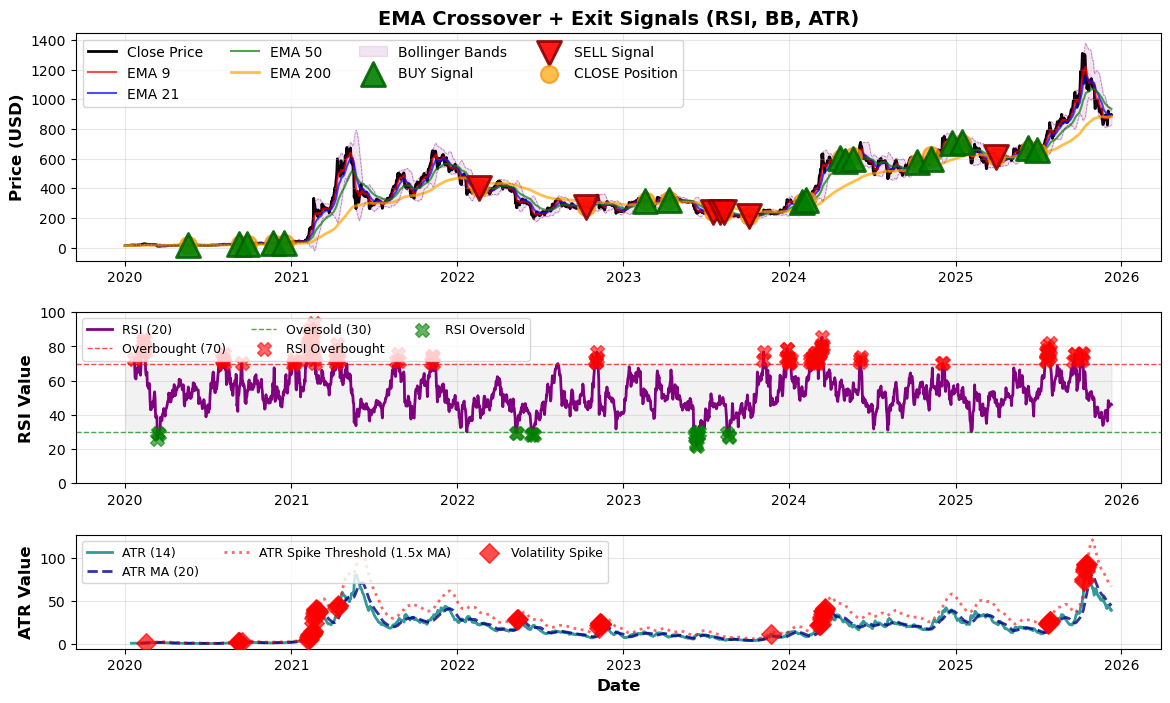


=== SIGNAL STATISTICS ===
Total BUY Signals:  18
Total SELL Signals: 7
Total CLOSE Signals: 25
Current Position: 0 (1=Long, -1=Short, 0=Flat)


In [20]:
# --- Enhanced Visualization: Entry & Exit Signals with Technical Indicators ---
fig = plt.figure(figsize=(14, 8))
gs = fig.add_gridspec(3, 1, height_ratios=[2, 1.5, 1], hspace=0.3)

ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1], sharex=ax1)
ax3 = fig.add_subplot(gs[2], sharex=ax1)

# Get price column
close_prices = df['close']

# ===== TOP PANEL: Price + EMAs + Entry/Exit Signals =====
ax1.plot(df.index, close_prices, linewidth=2, color='black', label='Close Price', zorder=1)
ax1.plot(df.index, df['EMA_9'], linewidth=1.5, color='red', alpha=0.7, label='EMA 9')
ax1.plot(df.index, df['EMA_21'], linewidth=1.5, color='blue', alpha=0.7, label='EMA 21')
ax1.plot(df.index, df['EMA_50'], linewidth=1.5, color='green', alpha=0.7, label='EMA 50')
ax1.plot(df.index, df['EMA_200'], linewidth=2, color='orange', alpha=0.7, label='EMA 200')

# Bollinger Bands
ax1.fill_between(df.index, df['bb_lower'], df['bb_upper'], alpha=0.1, color='purple', label='Bollinger Bands')
ax1.plot(df.index, df['bb_lower'], linewidth=0.5, color='purple', alpha=0.5, linestyle='--')
ax1.plot(df.index, df['bb_upper'], linewidth=0.5, color='purple', alpha=0.5, linestyle='--')
ax1.plot(df.index, df['bb_middle'], linewidth=0.5, color='purple', alpha=0.5, linestyle=':')

# Entry signals (BUY = 1)
buy_signals = df[df['signal'] == 1]
ax1.scatter(buy_signals.index, close_prices.loc[buy_signals.index], 
           marker='^', s=300, color='green', alpha=0.9, label='BUY Signal', zorder=5, edgecolors='darkgreen', linewidth=2)

# Entry signals (SELL = -1)
sell_signals = df[df['signal'] == -1]
ax1.scatter(sell_signals.index, close_prices.loc[sell_signals.index], 
           marker='v', s=300, color='red', alpha=0.9, label='SELL Signal', zorder=5, edgecolors='darkred', linewidth=2)

# Exit signals (CLOSE = 0, but only mark transitions)
close_signals = df[df['position'] < 0]  # When position changes from 1 to 0 or -1 to 0
ax1.scatter(close_signals.index, close_prices.loc[close_signals.index], 
           marker='o', s=150, color='orange', alpha=0.7, label='CLOSE Position', zorder=4, edgecolors='darkorange', linewidth=1.5)

ax1.set_ylabel('Price (USD)', fontsize=12, fontweight='bold')
ax1.set_title('EMA Crossover + Exit Signals (RSI, BB, ATR)', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.legend(loc='upper left', fontsize=10, ncol=4)

# ===== MIDDLE PANEL: RSI + Bollinger Bands for Exit Signal =====
ax2.plot(df.index, df['rsi'], linewidth=2, color='purple', label='RSI (20)')
ax2.axhline(y=70, color='red', linestyle='--', linewidth=1, alpha=0.7, label='Overbought (70)')
ax2.axhline(y=30, color='green', linestyle='--', linewidth=1, alpha=0.7, label='Oversold (30)')
ax2.fill_between(df.index, 30, 70, alpha=0.1, color='gray')

# Highlight RSI exit zones
rsi_overbought = df[df['rsi'] > 70]
ax2.scatter(rsi_overbought.index, rsi_overbought['rsi'], 
           marker='X', s=100, color='red', alpha=0.6, zorder=5, label='RSI Overbought')

rsi_oversold = df[df['rsi'] < 30]
ax2.scatter(rsi_oversold.index, rsi_oversold['rsi'], 
           marker='X', s=100, color='green', alpha=0.6, zorder=5, label='RSI Oversold')

ax2.set_ylabel('RSI Value', fontsize=12, fontweight='bold')
ax2.set_ylim([0, 100])
ax2.grid(True, alpha=0.3)
ax2.legend(loc='upper left', fontsize=9, ncol=3)

# ===== BOTTOM PANEL: ATR for Volatility Exit Signal =====
atr_mean = df['atr'].rolling(20).mean()
atr_spike_threshold = atr_mean * 1.5

ax3.plot(df.index, df['atr'], linewidth=2, color='teal', label='ATR (14)', alpha=0.8)
ax3.plot(df.index, atr_mean, linewidth=2, color='darkblue', label='ATR MA (20)', alpha=0.8, linestyle='--')
ax3.plot(df.index, atr_spike_threshold, linewidth=2, color='red', label='ATR Spike Threshold (1.5x MA)', alpha=0.6, linestyle=':')

# Highlight ATR spikes
atr_spikes = df[df['atr'] > atr_spike_threshold]
ax3.scatter(atr_spikes.index, atr_spikes['atr'], 
           marker='D', s=100, color='red', alpha=0.7, zorder=5, label='Volatility Spike')

ax3.set_ylabel('ATR Value', fontsize=12, fontweight='bold')
ax3.set_xlabel('Date', fontsize=12, fontweight='bold')
ax3.grid(True, alpha=0.3)
ax3.legend(loc='upper left', fontsize=9, ncol=3)

plt.tight_layout()
plt.show()

# Print signal statistics
print("\n=== SIGNAL STATISTICS ===")
print(f"Total BUY Signals:  {len(buy_signals)}")
print(f"Total SELL Signals: {len(sell_signals)}")
print(f"Total CLOSE Signals: {len(close_signals)}")
print(f"Current Position: {df['signal'].iloc[-1]} (1=Long, -1=Short, 0=Flat)")

In [21]:
# --- Analyze Exit Conditions Triggered ---
def analyze_exit_conditions(dataframe):
    """
    Analyze which exit conditions are most frequently triggered
    """
    df_analysis = dataframe.copy()  
    
    # Pre-calculate ATR rolling mean for the entire dataframe
    df_analysis['atr_ma20'] = df_analysis['atr'].rolling(20).mean()
    df_analysis['atr_spike_threshold'] = df_analysis['atr_ma20'] * 1.5
    
    # Detect when we close positions (signal changes from 1 to 0 or -1 to 0)
    long_exits = df_analysis[(df_analysis['signal'] == 0) & (df_analysis['signal'].shift(1) == 1)].copy()
    short_exits = df_analysis[(df_analysis['signal'] == 0) & (df_analysis['signal'].shift(1) == -1)].copy()
    
    print("\n=== LONG EXIT ANALYSIS ===")
    print(f"Total Long Exits: {len(long_exits)}\n")
    
    if len(long_exits) > 0:
        # Check which conditions triggered
        rsi_exits = long_exits[long_exits['rsi'] > 70].shape[0]
        bb_exits = long_exits[long_exits['close'] < long_exits['bb_lower']].shape[0]
        ema_exits = long_exits[long_exits['EMA_9'] < long_exits['EMA_50']].shape[0]
        atr_exits = long_exits[long_exits['atr'] > long_exits['atr_spike_threshold']].shape[0]
        
        print(f"  RSI > 70 (Overbought):        {rsi_exits} exits ({rsi_exits/len(long_exits)*100:.1f}%)")
        print(f"  Price < BB Lower:            {bb_exits} exits ({bb_exits/len(long_exits)*100:.1f}%)")
        print(f"  EMA 9 < EMA 50 (Momentum):   {ema_exits} exits ({ema_exits/len(long_exits)*100:.1f}%)")
        print(f"  ATR Spike (Volatility):      {atr_exits} exits ({atr_exits/len(long_exits)*100:.1f}%)")
        
        # Show recent long exits
        print("\n  Recent Long Exits (last 5):")
        for idx, row in long_exits.tail(5).iterrows():
            triggers = []
            if row['rsi'] > 70:
                triggers.append(f"RSI={row['rsi']:.1f}")
            if row['close'] < row['bb_lower']:
                triggers.append("BB Lower")
            if row['EMA_9'] < row['EMA_50']:
                triggers.append("EMA 9<50")
            # Use precomputed threshold column instead of rolling on scalar
            if row.get('atr_spike_threshold', None) is not None and row['atr'] > row['atr_spike_threshold']:
                triggers.append("ATR Spike")
            
            print(f"    {idx.date()} @ ${row['close']:.2f} → {', '.join(triggers) if triggers else 'Mixed'}")
    
    print("\n=== SHORT EXIT ANALYSIS ===")
    print(f"Total Short Exits: {len(short_exits)}\n")
    
    if len(short_exits) > 0:
        # Check which conditions triggered
        rsi_exits = short_exits[short_exits['rsi'] < 30].shape[0]
        bb_exits = short_exits[short_exits['close'] > short_exits['bb_upper']].shape[0]
        ema_exits = short_exits[short_exits['EMA_9'] > short_exits['EMA_50']].shape[0]
        atr_exits = short_exits[short_exits['atr'] > short_exits['atr_spike_threshold']].shape[0]
        
        print(f"  RSI < 30 (Oversold):         {rsi_exits} exits ({rsi_exits/len(short_exits)*100:.1f}%)")
        print(f"  Price > BB Upper:            {bb_exits} exits ({bb_exits/len(short_exits)*100:.1f}%)")
        print(f"  EMA 9 > EMA 50 (Momentum):   {ema_exits} exits ({ema_exits/len(short_exits)*100:.1f}%)")
        print(f"  ATR Spike (Volatility):      {atr_exits} exits ({atr_exits/len(short_exits)*100:.1f}%)")
        
        # Show recent short exits
        print("\n  Recent Short Exits (last 5):")
        for idx, row in short_exits.tail(5).iterrows():
            triggers = []
            if row['rsi'] < 30:
                triggers.append(f"RSI={row['rsi']:.1f}")
            if row['close'] > row['bb_upper']:
                triggers.append("BB Upper")
            if row['EMA_9'] > row['EMA_50']:
                triggers.append("EMA 9>50")
            # Use precomputed threshold column instead of rolling on scalar
            if row.get('atr_spike_threshold', None) is not None and row['atr'] > row['atr_spike_threshold']:
                triggers.append("ATR Spike")
            
            print(f"    {idx.date()} @ ${row['close']:.2f} → {', '.join(triggers) if triggers else 'Mixed'}")

analyze_exit_conditions(df) 



=== LONG EXIT ANALYSIS ===
Total Long Exits: 18

  RSI > 70 (Overbought):        0 exits (0.0%)
  Price < BB Lower:            0 exits (0.0%)
  EMA 9 < EMA 50 (Momentum):   0 exits (0.0%)
  ATR Spike (Volatility):      0 exits (0.0%)

  Recent Long Exits (last 5):
    2024-11-09 @ $624.37 → Mixed
    2024-12-26 @ $688.36 → Mixed
    2025-01-16 @ $708.30 → Mixed
    2025-06-11 @ $667.67 → Mixed
    2025-07-01 @ $646.40 → Mixed

=== SHORT EXIT ANALYSIS ===
Total Short Exits: 7

  RSI < 30 (Oversold):         0 exits (0.0%)
  Price > BB Upper:            0 exits (0.0%)
  EMA 9 > EMA 50 (Momentum):   0 exits (0.0%)
  ATR Spike (Volatility):      0 exits (0.0%)

  Recent Short Exits (last 5):
    2023-07-19 @ $241.16 → Mixed
    2023-08-03 @ $241.06 → Mixed
    2023-08-12 @ $240.27 → Mixed
    2023-10-05 @ $210.68 → Mixed
    2025-04-02 @ $590.64 → Mixed


In [22]:
# --- Enhanced Backtest Engine (dengan Exit Conditions) ---
def run_ema_backtest_with_exits(dataframe, entry_col='signal', price_col='close', 
                               initial_capital=100_000, commission=0.001, slippage=0.0):
    """
    Run vectorized backtest dengan entry & exit conditions.
    
    Parameters:
    - entry_col: Column name untuk signal (1=buy, -1=sell, 0=hold/close)
    - price_col: Column nama untuk price
    - initial_capital: Starting capital (USD)
    - commission: Commission per trade (%)
    - slippage: Slippage per trade (%)
    """
    df_bt = dataframe.copy()
    
    # Get price column
    close = df_bt[price_col]
    
    # Daily returns
    df_bt['returns'] = close.pct_change().fillna(0)
    
    # Build position state machine (1=long, -1=short, 0=flat)
    position = 0
    positions = []
    entry_price = None
    entry_idx = None
    
    for i, (idx, row) in enumerate(df_bt.iterrows()):
        sig = row[entry_col]
        
        if sig == 1:  # BUY signal
            position = 1
            entry_price = row[price_col]
            entry_idx = idx
        elif sig == -1:  # SELL signal
            position = -1
            entry_price = row[price_col]
            entry_idx = idx
        elif sig == 0 and position != 0:  # EXIT signal
            position = 0
            entry_price = None
            entry_idx = None
        
        positions.append(position)
    
    df_bt['Position'] = positions
    
    # Strategy return = position lagged * market return - costs
    df_bt['strategy_ret'] = df_bt['Position'].shift(1).fillna(0) * df_bt['returns']
    
    # Track trades (entry/exit)
    df_bt['trades'] = df_bt['Position'].diff().abs().fillna(0)
    
    # Reduce return by commission & slippage on trade days
    df_bt['strategy_ret'] -= df_bt['trades'] * (commission + slippage)
    
    # Equity curve
    df_bt['equity'] = initial_capital * (1 + df_bt['strategy_ret']).cumprod()
    
    # Metrics
    total_return = (df_bt['equity'].iloc[-1] / initial_capital) - 1
    
    # Annualized return (252 trading days)
    num_years = len(df_bt) / 252.0
    ann_return = (1 + total_return) ** (1 / num_years) - 1 if num_years > 0 else np.nan
    
    # Volatility
    ann_vol = df_bt['strategy_ret'].std() * np.sqrt(252)
    
    # Sharpe Ratio
    sharpe = (ann_return / ann_vol) if ann_vol > 0 else np.nan
    
    # Maximum Drawdown
    cumulative = (1 + df_bt['strategy_ret']).cumprod()
    peak = cumulative.cummax()
    drawdown = (cumulative - peak) / peak
    max_dd = drawdown.min()
    
    # Count winning trades
    long_trades = []
    short_trades = []
    position_state = 0
    entry_price_val = None
    entry_idx_val = None
    
    for i, (idx, row) in enumerate(df_bt.iterrows()):
        if row['Position'] != position_state:
            if position_state == 1:  # Exiting long
                long_trades.append({
                    'entry': entry_price_val,
                    'exit': row[price_col],
                    'profit': (row[price_col] - entry_price_val) / entry_price_val
                })
            elif position_state == -1:  # Exiting short
                short_trades.append({
                    'entry': entry_price_val,
                    'exit': row[price_col],
                    'profit': (entry_price_val - row[price_col]) / entry_price_val
                })
            
            position_state = row['Position']
            entry_price_val = row[price_col]
            entry_idx_val = idx
    
    # Calculate win rate
    all_trades = long_trades + short_trades
    winning_trades = [t for t in all_trades if t['profit'] > 0]
    win_rate = (len(winning_trades) / len(all_trades) * 100) if len(all_trades) > 0 else 0
    profit_factor = sum(t['profit'] for t in winning_trades) / abs(sum(t['profit'] for t in [t for t in all_trades if t['profit'] <= 0])) if any(t['profit'] <= 0 for t in all_trades) else 0
    
    metrics = {
        'Total Return': f'{total_return:.2%}',
        'Annualized Return': f'{ann_return:.2%}',
        'Annualized Volatility': f'{ann_vol:.2%}',
        'Sharpe Ratio': f'{sharpe:.2f}',
        'Max Drawdown': f'{max_dd:.2%}',
        'Win Rate': f'{win_rate:.1f}%',
        'Profit Factor': f'{profit_factor:.2f}',
        'Total Trades': len(all_trades),
        'Long Trades': len(long_trades),
        'Short Trades': len(short_trades),
        'Final Equity': f'${df_bt["equity"].iloc[-1]:,.0f}'
    }
    
    return df_bt, metrics

# Run enhanced backtest
bt_df_enhanced, bt_metrics_enhanced = run_ema_backtest_with_exits(df)

# Display metrics
print("\n" + "="*50)
print("BACKTEST RESULTS (WITH EXIT CONDITIONS)")
print("="*50)
for key, val in bt_metrics_enhanced.items():
    print(f"{key:.<35} {val}")
print("="*50)


BACKTEST RESULTS (WITH EXIT CONDITIONS)
Total Return....................... 2.85%
Annualized Return.................. 0.33%
Annualized Volatility.............. 3.50%
Sharpe Ratio....................... 0.09
Max Drawdown....................... -8.08%
Win Rate........................... 36.0%
Profit Factor...................... 1.57
Total Trades....................... 25
Long Trades........................ 18
Short Trades....................... 7
Final Equity....................... $102,849


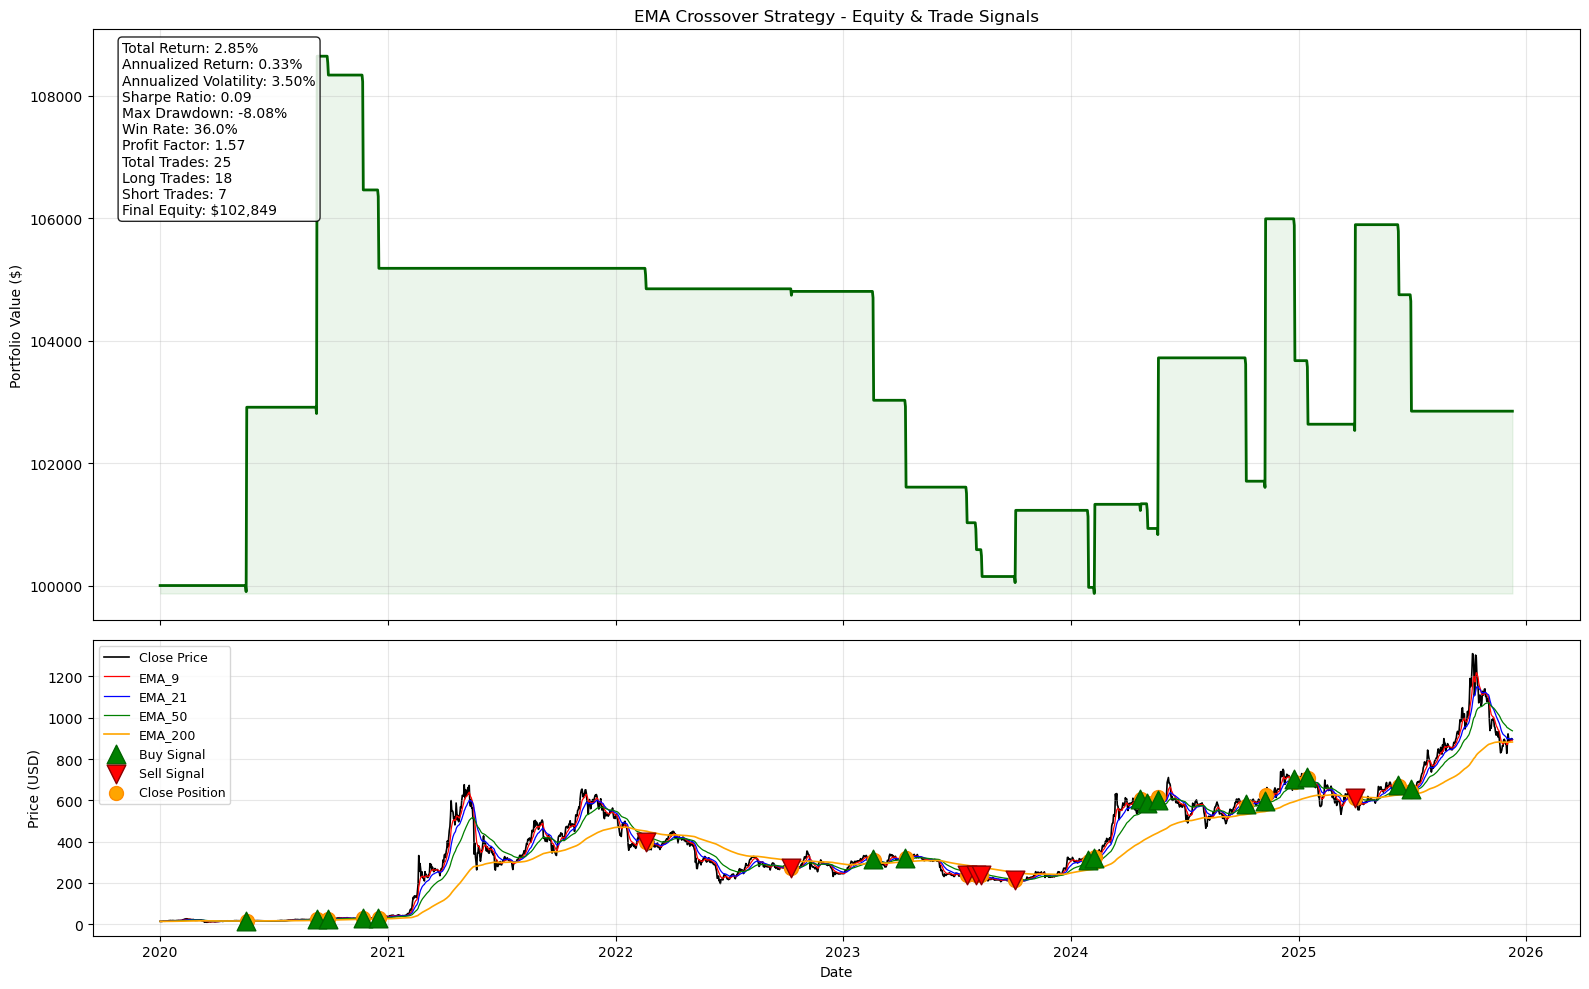

Total Signals: 25  (Buy: 18, Sell: 7)


In [23]:
# --- Visualization: Equity Curve + Trade Signals ---
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 10), sharex=True, gridspec_kw={'height_ratios': [2, 1]})

# Top panel: Equity Curve
eq = bt_df_enhanced['equity']
ax1.plot(eq.index, eq, color='darkgreen', linewidth=2, label='Strategy Equity')
ax1.fill_between(eq.index, eq.min(), eq, color='green', alpha=0.08)
ax1.set_ylabel('Portfolio Value ($)')
ax1.set_title('EMA Crossover Strategy - Equity & Trade Signals')
ax1.grid(True, alpha=0.3)

# Metrics textbox (use enhanced metrics)
metrics_text = '\n'.join([f"{k}: {v}" for k, v in bt_metrics_enhanced.items()])
ax1.text(0.02, 0.98, metrics_text, transform=ax1.transAxes, fontsize=10,
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.85))

# Bottom panel: Price + EMAs + Signals
ax2.plot(close_prices.index, close_prices, color='black', linewidth=1.2, label='Close Price', zorder=1)
for ema, color, lw in [('EMA_9', 'red', 0.9), ('EMA_21', 'blue', 0.9), ('EMA_50', 'green', 0.9), ('EMA_200', 'orange', 1.2)]:
    if ema in df.columns:
        ax2.plot(df.index, df[ema], color=color, linewidth=lw, label=ema)

# Plot signals if available
if 'buy_signals' in globals() and not buy_signals.empty:
    ax2.scatter(buy_signals.index, buy_signals['close'], marker='^', s=180, color='green',
                edgecolors='darkgreen', label='Buy Signal', zorder=5)
if 'sell_signals' in globals() and not sell_signals.empty:
    ax2.scatter(sell_signals.index, sell_signals['close'], marker='v', s=180, color='red',
                edgecolors='darkred', label='Sell Signal', zorder=5)
if 'close_signals' in globals() and not close_signals.empty:
    ax2.scatter(close_signals.index, close_signals['close'], marker='o', s=100, color='orange',
                edgecolors='darkorange', label='Close Position', zorder=4)

ax2.set_ylabel('Price (USD)')
ax2.set_xlabel('Date')
ax2.grid(True, alpha=0.3)
ax2.legend(loc='upper left', fontsize=9)

plt.tight_layout()
plt.show()

# Quick counts
buy_count = len(buy_signals) if 'buy_signals' in globals() else df['signal'].eq(1).sum()
sell_count = len(sell_signals) if 'sell_signals' in globals() else df['signal'].eq(-1).sum()
print(f"Total Signals: {buy_count + sell_count}  (Buy: {buy_count}, Sell: {sell_count})")

Running extended optimization for 56 combinations...

Top 10 results:
 EMA_Fast  EMA_Medium  Total_Return  Sharpe  Max_DD  Win_Rate  Total_Trades
        9          27        0.1700    0.61 -0.0439      75.0            12
       10          25        0.1660    0.52 -0.0537      62.5            16
        8          29        0.1138    0.43 -0.0397      66.7            12
       10          23        0.1123    0.32 -0.0977      70.0            20
        9          25        0.1192    0.31 -0.1195      60.0            20
       12          27        0.0498    0.29 -0.0305      62.5             8
       10          29        0.0486    0.22 -0.0657      66.7             9
       12          21        0.0702    0.21 -0.1067      57.9            19
       11          25        0.0489    0.20 -0.0786      54.5            11
       11          29        0.0410    0.18 -0.0725      66.7             9

Best found: EMA(9,27)  Sharpe=0.61  Return=17.00%
Current strategy: Sharpe=0.09  Return=2.85%

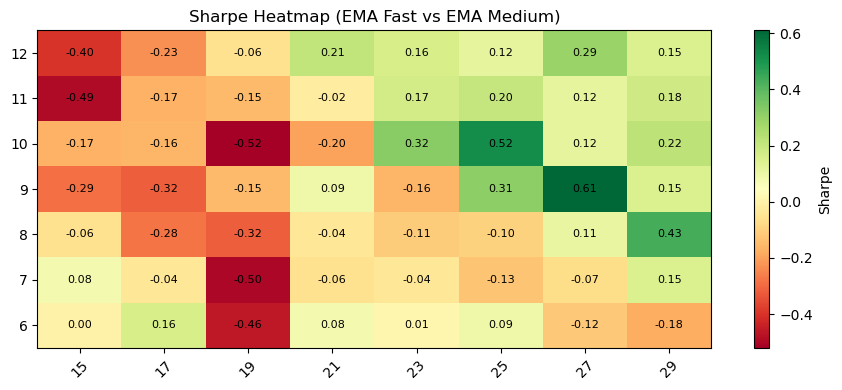

In [24]:
# Extended grid search for EMA fast/medium combos and visual summary
fast_range = range(6, 13)
med_range = range(15, 31, 2)
ema_pairs_grid = [(f, m) for f in fast_range for m in med_range if f < m]

# If function is not defined (cell order), define a local version that uses the available backtest
if 'optimize_ema_strategy' not in globals():
    def optimize_ema_strategy(dataframe, ema_pairs, test_long=200, test_mid=50):
        results = []
        for fast, medium in ema_pairs:
            try:
                df_opt = dataframe.copy()
                close = df_opt['close']  # use lowercase column names in this notebook

                # Compute EMAs
                df_opt['EMA_fast'] = close.ewm(span=fast, adjust=False).mean()
                df_opt['EMA_medium'] = close.ewm(span=medium, adjust=False).mean()
                df_opt['EMA_long'] = close.ewm(span=test_long, adjust=False).mean()
                df_opt['EMA_mid'] = close.ewm(span=test_mid, adjust=False).mean()

                # Generate signals
                df_opt['Signal_opt'] = 0
                Buy_Cond = (
                    (close > df_opt['EMA_long'].shift(1)) &
                    (df_opt['EMA_mid'].shift(1) > df_opt['EMA_long'].shift(1)) &
                    (df_opt['EMA_medium'].shift(1) > df_opt['EMA_mid'].shift(1)) &
                    (df_opt['EMA_fast'] > df_opt['EMA_medium']) &
                    (df_opt['EMA_fast'].shift(1) <= df_opt['EMA_medium'].shift(1))
                )
                df_opt.loc[Buy_Cond, 'Signal_opt'] = 1

                Sell_Cond = (
                    (close < df_opt['EMA_long'].shift(1)) &
                    (df_opt['EMA_mid'].shift(1) < df_opt['EMA_long'].shift(1)) &
                    (df_opt['EMA_medium'].shift(1) < df_opt['EMA_mid'].shift(1)) &
                    (df_opt['EMA_fast'] < df_opt['EMA_medium']) &
                    (df_opt['EMA_fast'].shift(1) >= df_opt['EMA_medium'].shift(1))
                )
                df_opt.loc[Sell_Cond, 'Signal_opt'] = -1

                # Use the backtest function available in this notebook
                bt_opt, metrics_opt = run_ema_backtest_with_exits(df_opt, entry_col='Signal_opt', price_col='close')

                sharpe_val = float(metrics_opt['Sharpe Ratio'])
                ret_val = float(metrics_opt['Total Return'].strip('%')) / 100
                dd_val = float(metrics_opt['Max Drawdown'].strip('%')) / 100

                results.append({
                    'EMA_Fast': fast,
                    'EMA_Medium': medium,
                    'EMA_Long': test_long,
                    'EMA_Mid': test_mid,
                    'Total_Return': ret_val,
                    'Sharpe': sharpe_val,
                    'Max_DD': dd_val,
                    'Win_Rate': float(metrics_opt['Win Rate'].strip('%')),
                    'Total_Trades': metrics_opt['Total Trades']
                })
            except Exception as e:
                print(f"  Error with EMA({fast},{medium}): {str(e)[:100]}")
                continue

        results_df = pd.DataFrame(results)
        return results_df.sort_values('Sharpe', ascending=False)

print(f"Running extended optimization for {len(ema_pairs_grid)} combinations...")
opt_results_grid = optimize_ema_strategy(df, ema_pairs_grid, test_long=200, test_mid=50)

# show top 10 (safeguard if results empty)
display_cols = ['EMA_Fast', 'EMA_Medium', 'Total_Return', 'Sharpe', 'Max_DD', 'Win_Rate', 'Total_Trades']
if opt_results_grid.empty:
    print("No optimization results produced.")
else:
    print("\nTop 10 results:")
    print(opt_results_grid[display_cols].head(10).to_string(index=False))

    # compare best with current strategy
    best = opt_results_grid.iloc[0]
    print(f"\nBest found: EMA({int(best['EMA_Fast'])},{int(best['EMA_Medium'])})  Sharpe={best['Sharpe']:.2f}  Return={best['Total_Return']:.2%}")
    print(f"Current strategy: Sharpe={float(bt_metrics_enhanced['Sharpe Ratio']):.2f}  Return={float(bt_metrics_enhanced['Total Return'].strip('%'))/100:.2%}")

    # Heatmap of Sharpe ratio
    pivot = opt_results_grid.pivot(index='EMA_Fast', columns='EMA_Medium', values='Sharpe').sort_index()
    plt.figure(figsize=(9, 4))
    plt.imshow(pivot.values, aspect='auto', cmap='RdYlGn', origin='lower')
    plt.colorbar(label='Sharpe')
    plt.xticks(range(len(pivot.columns)), pivot.columns, rotation=45)
    plt.yticks(range(len(pivot.index)), pivot.index)
    plt.title('Sharpe Heatmap (EMA Fast vs EMA Medium)')
    for i, row in enumerate(pivot.values):
        for j, val in enumerate(row):
            if not np.isnan(val):
                plt.text(j, i, f"{val:.2f}", ha='center', va='center', fontsize=8)
    plt.tight_layout()
    plt.show()

In [ ]:
# 